### Maestría en Ciudades Sostenibles

# Manejo y Análisis de Datos
***
## Investigando Distribuciones

Mateo Neira
***

# Modelos de Clasificación (Parte 1)

**Objetivo:** Entrenar, predecir y evaluar nuestros primeros modelos de clasificación: Regresión Logística y K-Vecinos más Cercanos (k-NN).

### Scikit-learn

En el cuaderno de esta semana aprenderemos a usar algunas bibliotecas de Python relacionadas con el aprendizaje automático. ```Scikit-learn``` (anteriormente scikits.learn y también abreviado como ```sklearn```) es una biblioteca de aprendizaje automático, una de las más conocidas y utilizadas en Python y abarca funciones para muchos propósitos. 

Presenta varios algoritmos de clasificación, regresión y agrupamiento, que incluyen regresión lineal, árbol de decisión, máquinas de vectores de soporte, bosques aleatorios, k-medias y DBSCAN, y está diseñado para interoperar con las bibliotecas científicas y numéricas de Python ```NumPy``` y ```SciPy```.

Para este cuaderno de Jupyter, repasaremos dos ejemplos de las muchas aplicaciones de ```sklearn```. Puede notar a continuación que importamos solo ciertas porciones del paquete ```sklearn```, y esto es para conservar la memoria en su sistema operativo importando solo lo que usaremos.

Para obtener más información, consulte [el sitio web oficial](httpss://scikit-learn.org/).


In [1]:
# 1. Importar Librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn para modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Scikit-learn para evaluación
from sklearn.metrics import confusion_matrix, classification_report

# Configuración de estilo
sns.set_theme(style="whitegrid")

Crear un Dataset Simulado (para nuestro ejemplo)

Crearemos un dataset de zonas urbanas para predecir si una zona tiene un alto tráfico peatonal.

*   **Variables predictoras:**
    *   `densidad_poblacion`: Habitantes por km².
    *   `num_comercios`: Número de tiendas, bares, etc.
    *   `distancia_parque`: Distancia en metros al parque más cercano.
*   **Variable objetivo:**
    *   `alto_trafico_peatonal`: 1 (Sí) o 0 (No).

In [2]:
# Semilla para reproducibilidad
np.random.seed(42)

# Generar datos
n_zonas = 300
data = {
    'densidad_poblacion': np.random.normal(5000, 1500, n_zonas).clip(500),
    'num_comercios': np.random.poisson(30, n_zonas) + np.random.randint(-10, 10, n_zonas),
    'distancia_parque': np.random.uniform(50, 1000, n_zonas)
}
df = pd.DataFrame(data)

# Crear la variable objetivo
# El alto tráfico es más probable con alta densidad, muchos comercios y cercanía a un parque
probabilidad_trafico = (df['densidad_poblacion'] / 7000) + (df['num_comercios'] / 50) - (df['distancia_parque'] / 1500)
df['alto_trafico_peatonal'] = (probabilidad_trafico + np.random.normal(0, 0.2, n_zonas) > 0.8).astype(int)

print("Primeras filas del dataset:")
print(df.head())
print("\nBalance de clases:")
print(df['alto_trafico_peatonal'].value_counts())

Primeras filas del dataset:
   densidad_poblacion  num_comercios  distancia_parque  alto_trafico_peatonal
0         5745.071230             18        421.527460                      1
1         4792.603548             31        970.941706                      0
2         5971.532807             19        295.226761                      1
3         7284.544785             24        673.899831                      1
4         4648.769938             39        358.930561                      1

Balance de clases:
alto_trafico_peatonal
1    195
0    105
Name: count, dtype: int64


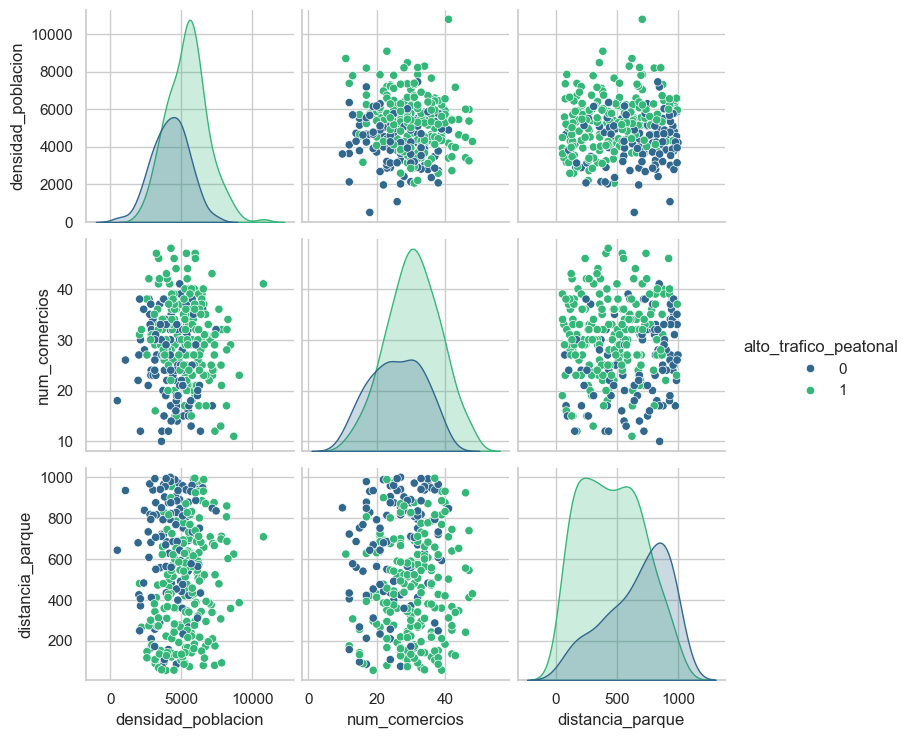

In [3]:
sns.pairplot(df, hue='alto_trafico_peatonal', palette='viridis')
plt.show()

## División de Datos (Train-Test Split)

Dividimos nuestros datos para poder entrenar el modelo con una parte y evaluarlo con otra que nunca ha visto.

En la mayoría de las aplicaciones de aprendizaje automático, es importante dividir el conjunto de datos que tiene en dos conjuntos: los conjuntos de entrenamiento y de prueba. La idea es entrenar/ajustar/configurar su modelo basándose en una fracción del conjunto de datos, pero probar su eficacia en el otro conjunto (de prueba). Esto simula hasta cierto punto cómo se desempeñaría el modelo que entrenó en un conjunto de datos no visto y, por lo tanto, es una prueba para el rendimiento del modelo que creó y qué tan bien se generaliza, es decir, ¿está sobreajustado al conjunto de datos que utilizó para crearlo, de modo que tiene poco valor cuando se usa para predecir resultados en otro conjunto de datos? Para obtener más información, puede encontrar información en línea, como en [este artículo](https://machinelearningmastery.com/difference-test-validation-datasets/).


In [4]:
# Definir X (variables predictoras) e y (variable objetivo)
X = df.drop('alto_trafico_peatonal', axis=1)
y = df['alto_trafico_peatonal']

# Dividir los datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

Tamaño del conjunto de entrenamiento: 240
Tamaño del conjunto de prueba: 60


Modelo 1: Regresión Logística

Este es un buen primer modelo para problemas de clasificación. Es rápido y fácil de interpretar.

### Aprendizaje Supervisado - Regresión Logística

Un modelo de Regresión Logística es una variante de los modelos lineales generalizados (una función <b>(logística)</b> como función de enlace) que se utiliza normalmente para la clasificación. Estos modelos predicen la <b> probabilidad</b> de que ocurra un determinado evento o categorización: en función de las variables definidas por el usuario, a cada observación se le asignará una probabilidad de entre 0 y 1 en la salida (evento/clase) de que ocurra.

Posteriormente, las observaciones se pueden clasificar en 2 o más clases en función de umbrales definidos por el usuario. Por ejemplo, si quisiéramos usar el modelo para predecir la probabilidad de que ocurra un deslizamiento de tierra en una determinada región, podríamos asignar observaciones con una probabilidad > 0.5 a la clase =1 (es probable que ocurran deslizamientos de tierra) y las observaciones restantes a la clase =0 (es poco probable que ocurran deslizamientos de tierra).

La función de regresión logística en ```sklearn``` implementa la regresión logística regularizada para dar una salida predicha de 2 o más clases. Lea más al respecto [aquí](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).


In [5]:
# Instanciar y entrenar el modelo
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_log = log_reg.predict(X_test)

# Evaluar el modelo
print("--- Evaluación de la Regresión Logística ---")
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_log))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_log, target_names=['Tráfico Bajo', 'Tráfico Alto']))

--- Evaluación de la Regresión Logística ---

Matriz de Confusión:
[[15  6]
 [ 6 33]]

Reporte de Clasificación:
              precision    recall  f1-score   support

Tráfico Bajo       0.71      0.71      0.71        21
Tráfico Alto       0.85      0.85      0.85        39

    accuracy                           0.80        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.80      0.80      0.80        60



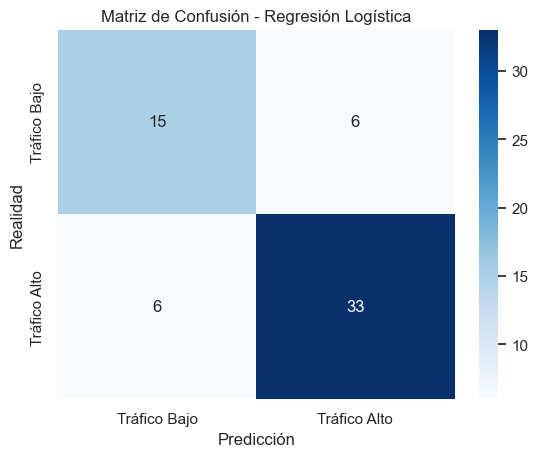

In [6]:
#visualizar matriz de confusión en un heatmap
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=['Tráfico Bajo', 'Tráfico Alto'], yticklabels=['Tráfico Bajo', 'Tráfico Alto'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

### Modelo 2: K-Vecinos más Cercanos (k-NN)

k-NN es un modelo basado en distancia, por lo que es **crucial escalar las variables** antes de entrenarlo. Si no lo hacemos, la `densidad_poblacion` (con valores en miles) dominará completamente a `num_comercios` (con valores en decenas).

#### Escalado de Variables

In [7]:
# Instanciar el escalador
scaler = StandardScaler()

# Ajustar el escalador SÓLO con los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba con el escalador ya ajustado
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para visualización (opcional)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
print("Datos de entrenamiento escalados (primeras 5 filas):")
print(X_train_scaled_df.head())

Datos de entrenamiento escalados (primeras 5 filas):
   densidad_poblacion  num_comercios  distancia_parque
0            0.301352       1.605929         -1.035705
1            0.793647      -1.260132         -0.816296
2           -1.110397       0.858261         -0.217261
3            1.637871       0.235204         -0.029298
4           -0.315552       0.982872         -0.629536


### Entrenamiento y Evaluación de k-NN

In [8]:
# Instanciar y entrenar el modelo (usaremos k=5 como punto de partida)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Hacer predicciones en el conjunto de prueba escalado
y_pred_knn = knn.predict(X_test_scaled)

# Evaluar el modelo
print("--- Evaluación de k-NN (k=5) ---")
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_knn, target_names=['Tráfico Bajo', 'Tráfico Alto']))

--- Evaluación de k-NN (k=5) ---

Matriz de Confusión:
[[13  8]
 [ 6 33]]

Reporte de Clasificación:
              precision    recall  f1-score   support

Tráfico Bajo       0.68      0.62      0.65        21
Tráfico Alto       0.80      0.85      0.82        39

    accuracy                           0.77        60
   macro avg       0.74      0.73      0.74        60
weighted avg       0.76      0.77      0.76        60



### Conclusión

Comparamos los resultados de ambos modelos. La Regresión Logística nos da un buen punto de partida y es muy interpretable. El k-NN, después de escalar los datos, también puede ser muy efectivo. En este caso, sus resultados son bastante similares. En futuros tutoriales, veremos cómo optimizar la elección de 'k' y explorar modelos más complejos.

## Modelos de Clasificación (Parte 2) - Árboles y Bosques


**Objetivo:** Entrenar y evaluar modelos basados en árboles: el Árbol de Decisión y el Random Forest, y comparar su rendimiento con los modelos anteriores.

In [9]:
# 1. Importar Librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn para modelado
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn para evaluación
from sklearn.metrics import confusion_matrix, classification_report

# Configuración de estilo
sns.set_theme(style="whitegrid")

## 2. Cargar y Preparar los Datos

Para poder comparar los modelos, usaremos exactamente el mismo dataset y la misma división `train-test` que en el tutorial anterior.

In [10]:
# Semilla para reproducibilidad
np.random.seed(42)

# Generar datos (mismo código que en el tutorial 3)
n_zonas = 300
data = {
    'densidad_poblacion': np.random.normal(5000, 1500, n_zonas).clip(500),
    'num_comercios': np.random.poisson(30, n_zonas) + np.random.randint(-10, 10, n_zonas),
    'distancia_parque': np.random.uniform(50, 1000, n_zonas)
}
df = pd.DataFrame(data)
probabilidad_trafico = (df['densidad_poblacion'] / 7000) + (df['num_comercios'] / 50) - (df['distancia_parque'] / 1500)
df['alto_trafico_peatonal'] = (probabilidad_trafico + np.random.normal(0, 0.2, n_zonas) > 0.8).astype(int)

# Definir X e y
X = df.drop('alto_trafico_peatonal', axis=1)
y = df['alto_trafico_peatonal']

# Dividir los datos (misma división que en el tutorial 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Datos listos para modelar.")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

Datos listos para modelar.
Tamaño del conjunto de entrenamiento: 240
Tamaño del conjunto de prueba: 60


### Modelo 3: Árbol de Decisión

Los árboles de decisión son potentes y fáciles de interpretar. Sin embargo, pueden sobreajustar fácilmente si no limitamos su complejidad. Usaremos `max_depth` para controlar su profundidad.

In [11]:
# Instanciar y entrenar el modelo
# Limitamos la profundidad a 4 para evitar el sobreajuste y facilitar la visualización
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(X_train, y_train)

# Hacer predicciones
y_pred_tree = tree_clf.predict(X_test)

# Evaluar el modelo
print("--- Evaluación del Árbol de Decisión (max_depth=4) ---")
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_tree))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_tree, target_names=['Tráfico Bajo', 'Tráfico Alto']))

--- Evaluación del Árbol de Decisión (max_depth=4) ---

Matriz de Confusión:
[[16  5]
 [ 8 31]]

Reporte de Clasificación:
              precision    recall  f1-score   support

Tráfico Bajo       0.67      0.76      0.71        21
Tráfico Alto       0.86      0.79      0.83        39

    accuracy                           0.78        60
   macro avg       0.76      0.78      0.77        60
weighted avg       0.79      0.78      0.79        60



Text(0.5, 19.987499999999997, 'Predicción')

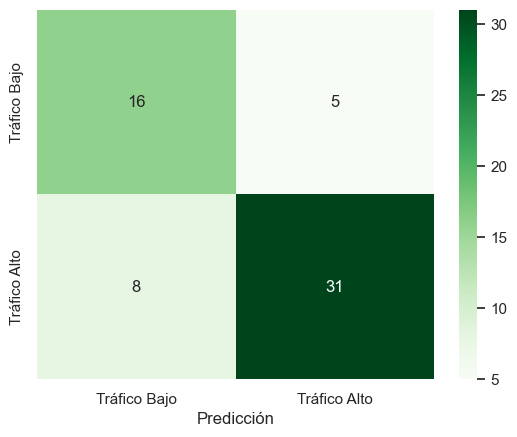

In [12]:
#visualizar matriz de confusión en un heatmap
cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Tráfico Bajo', 'Tráfico Alto'], 
            yticklabels=['Tráfico Bajo', 'Tráfico Alto'])
plt.xlabel('Predicción')

### Visualización del Árbol de Decisión

Una de las grandes ventajas de los árboles es que podemos ver exactamente las "reglas" que han aprendido.

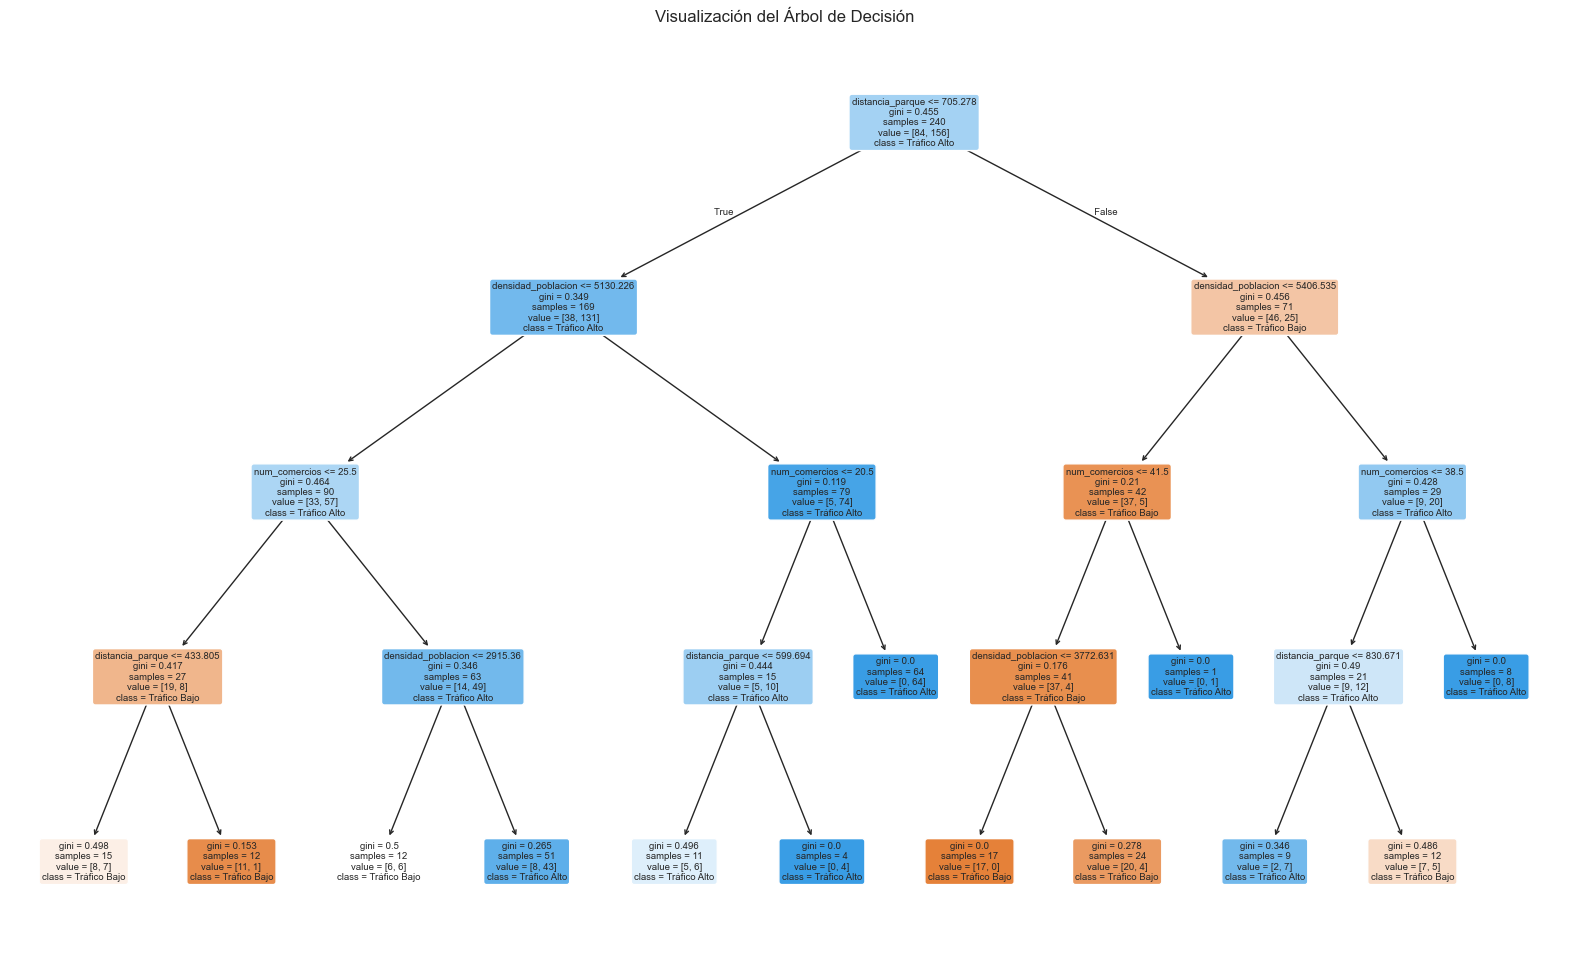

In [13]:
plt.figure(figsize=(20, 12))
plot_tree(
    tree_clf,
    filled=True,
    rounded=True,
    class_names=['Tráfico Bajo', 'Tráfico Alto'],
    feature_names=X.columns
)
plt.title("Visualización del Árbol de Decisión")
plt.show()

# Modelo 4: Random Forest

El Random Forest entrena muchos árboles de decisión sobre subconjuntos de datos y características para crear un modelo más robusto y preciso.

In [14]:
# Instanciar y entrenar el modelo
# n_estimators es el número de árboles en el bosque
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=4)
rf_clf.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf = rf_clf.predict(X_test)

# Evaluar el modelo
print("--- Evaluación del Random Forest ---")
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=['Tráfico Bajo', 'Tráfico Alto']))

--- Evaluación del Random Forest ---

Matriz de Confusión:
[[12  9]
 [ 6 33]]

Reporte de Clasificación:
              precision    recall  f1-score   support

Tráfico Bajo       0.67      0.57      0.62        21
Tráfico Alto       0.79      0.85      0.81        39

    accuracy                           0.75        60
   macro avg       0.73      0.71      0.72        60
weighted avg       0.74      0.75      0.75        60



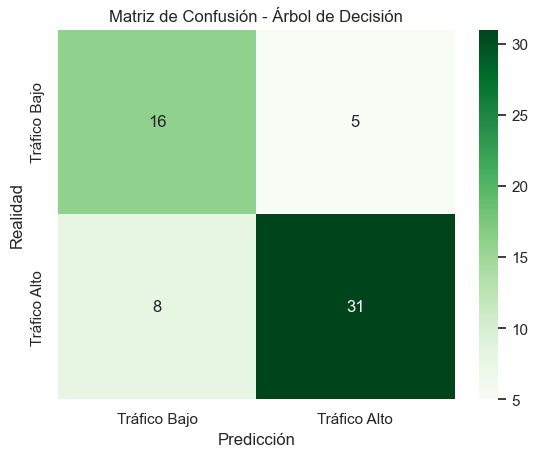

In [15]:
#visualizar matriz de confusión en un heatmap
cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens', xticklabels=['Tráfico Bajo', 'Tráfico Alto'], yticklabels=['Tráfico Bajo', 'Tráfico Alto'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

### Importancia de las Características (Feature Importance)

Una gran ventaja del Random Forest es que puede decirnos qué características fueron las más importantes para tomar sus decisiones.

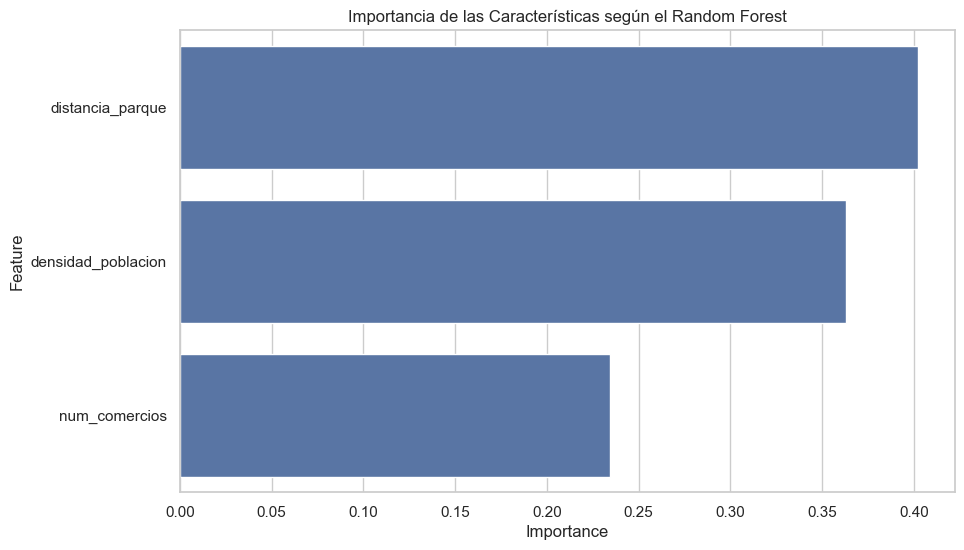

In [16]:
# Extraer la importancia de las características
importances = rf_clf.feature_importances_
feature_names = X.columns

# Crear un DataFrame para visualización
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características según el Random Forest')
plt.show()

### Conclusión

Hemos añadido dos potentes modelos a nuestro repertorio.

*   El **Árbol de Decisión** es increíblemente útil para entender las relaciones en los datos gracias a su interpretabilidad, pero es propenso a sobreajustar.
*   El **Random Forest** suele dar un mejor rendimiento y es más robusto, a costa de perder la interpretabilidad directa. Sin embargo, nos compensa dándonos la importancia de las características, lo cual es muy valioso.

En este caso, el Random Forest mejora ligeramente el rendimiento del árbol de decisión simple, mostrando el poder de los métodos de ensamble.

# Ejercicio
### El conjunto de datos Iris

El [conjunto de datos](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) con el que practicaremos es el conjunto de datos iris, quizás la base de datos más conocida que se puede encontrar en la literatura sobre reconocimiento de patrones. Este conjunto de datos consta de mediciones de 3 tipos diferentes de plantas de flores de iris (Setosa, Versicolour y Virginica), y sus longitudes y anchos de pétalos y sépalos individuales, medidos en centímetros. En su uso original, el biólogo Ronald Fisher desarrolló un modelo de clasificación para discriminar las flores en función de su especie a través de sus medidas.

```
from sklearn import datasets
datasets.load_iris()
```

Tenga en cuenta que en el conjunto de datos ```iris```, la variable ```target``` se refiere a la especie de cada planta de iris.

In [23]:
# cargar datos de iris
from sklearn import datasets
iris = datasets.load_iris()
print(type(iris))
print(iris.keys())

<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


1. explora los datos que cargamos y conviertelo en un dataframe. (hint: vas a tener que cargar el data y el target como dataframes separados y luego contatenar).

2. pre-procesamiento de caracteristicas. (hint, scikit-learn tiene un metodo sklearn.preprocessing.StandardScaler para realizare estandarizacion de los datos).

3. Divide los datos en datos de entrenamiento y datos de prueba

4. Define el modelo para la clasificacion

5. Ajustar el modelo

6. Reportar los resultados

